In [1]:
# Start with loading all necessary libraries
import pandas as pd
import xml.etree.ElementTree as et
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter
import re

# Import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer

# Import NMF
from sklearn.decomposition import NMF

from wordcloud import WordCloud

In [2]:
snomedct = pd.read_csv('sct2_Description_Snapshot-en_INT_20190731.txt',sep="\t",usecols=['term'])
medical_terms_series = snomedct['term'].str.lower().str.split().dropna()
medical_terms_list = []
for x in medical_terms_series:
    medical_terms_list.extend(x)
medical_terms_list = [medical_term for medical_term in medical_terms_list if medical_term.isalpha()]
medical_terms_list = [medical_term.strip("()") for medical_term in medical_terms_list]
medical_terms_list = [medical_term.strip("(s") for medical_term in medical_terms_list]
medical_terms_counts = Counter(medical_terms_list)

In [3]:
df_cols = ["created-at","description"]
rows = []
for i in range(407):
    xtree = et.parse("157808/Tickets_"+str(i)+".xml")
    xroot = xtree.getroot() 

    tickets = xtree.findall('helpdesk-ticket')
    for ticket in tickets:
        time = ticket.find('created-at')
        description = ticket.find('description')
        if time is not None and description is not None:
            rows.append({'created-at': time.text,'description':description.text})

df = pd.DataFrame(rows, columns = df_cols)
df.head()

,created-at,description
0,2018-04-01T01:18:00+01:00,AD Password Reset
1,2018-04-01T07:30:15+01:00,Sorry to bother you. A non-urgent issue I ...
2,2018-04-01T08:35:38+01:00,ICE labels are printing misaligned Cleare...
3,2018-04-01T08:55:10+01:00,Loraynne's password expired but it would not a...
4,2018-04-01T10:13:41+01:00,Automated account amendment request for beevor...


In [4]:
df['created-at'] = df['created-at'].str.split("+",n=1,expand=True)[0]
df.head()

,created-at,description
0,2018-04-01T01:18:00,AD Password Reset
1,2018-04-01T07:30:15,Sorry to bother you. A non-urgent issue I ...
2,2018-04-01T08:35:38,ICE labels are printing misaligned Cleare...
3,2018-04-01T08:55:10,Loraynne's password expired but it would not a...
4,2018-04-01T10:13:41,Automated account amendment request for beevor...


In [5]:
df['created-at'] = pd.to_datetime(df['created-at'],format='%Y-%m-%dT%H:%M:%S')
df

,created-at,description
0,2018-04-01 01:18:00,AD Password Reset
1,2018-04-01 07:30:15,Sorry to bother you. A non-urgent issue I ...
2,2018-04-01 08:35:38,ICE labels are printing misaligned Cleare...
3,2018-04-01 08:55:10,Loraynne's password expired but it would not a...
4,2018-04-01 10:13:41,Automated account amendment request for beevor...
5,2018-04-01 10:14:01,Reset users AD Password Confirmed access
6,2018-04-01 11:03:53,Hello would it be possible to reset my NHS.ne...
7,2018-04-01 11:59:49,Dear Sir or Madam Apology for the delay i...
8,2018-04-01 12:55:07,Julie's account was disabled. Un-ticked th...
9,2018-04-01 14:22:34,Please could you mend my out of office which i...


In [6]:
total_days = (max(df['created-at'])-min(df['created-at'])).days
print(total_days)

597


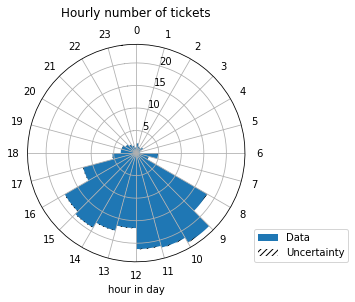

In [7]:
bins = [i-0.5 for i in range(25)]
data_x = [i for i in range(24)]

# Compute pie slices
N = 24
width = 2 * np.pi/N
theta = np.linspace(0.0 + width, 2 * np.pi + width, N, endpoint=False)
theta_deg = np.linspace(0.0 + 7.5, 360 + 7.5, N, endpoint=False)

def hour_plot(dataframe):
    data_y_tot,_ = np.histogram(dataframe['created-at'].dt.hour, bins=bins)
    radii = data_y_tot/total_days
    radii_err = np.sqrt(data_y_tot)/total_days

    ax = plt.subplot(111, projection='polar')
    ax.bar(theta, radii, width=width,label='Data');
    ax.bar(theta, radii_err, bottom=radii-radii_err/2,width=width,alpha=0.5,color='none',hatch="////",label='Uncertainty');
    ax.set_theta_offset(np.pi/2 + width/2)
    ax.set_theta_direction(-1)
    plt.xlabel('hour in day')
    plt.title('Hourly number of tickets',y=1.1)
    plt.legend(loc=(1.04,0))
    lines, labels = plt.thetagrids( theta_deg, (data_x) )
    plt.show()
hour_plot(df)

In [8]:
df = df.dropna()
consecutive_caps_series = df[~df['description'].str.isupper()]['description'].str.findall(r"\b[a-z]{2,}\b\s\b[A-Z]{2,}\b\s\b[a-z]{2,}\b")
consecutive_caps_series = consecutive_caps_series[consecutive_caps_series.map(lambda d: len(d)) > 0]
slist = []
for x in consecutive_caps_series:
    slist.extend(x)

# function to get unique values 
def unique(list1): 
  
    # intilize a null list 
    unique_list = [] 
      
    # traverse for all elements 
    for x in list1: 
        # check if exists in unique_list or not 
        if x.split()[1] not in unique_list: 
            unique_list.append(x.split()[1])
    return [string.lower() for string in unique_list]
        
abbreviations = [l.split()[1].lower() for l in slist]
abbreviation_counts = Counter(abbreviations)
print(abbreviation_counts)

Counter({'it': 942, 'pas': 778, 'ice': 714, 'pc': 659, 'esr': 435, 'vnc': 416, 'pht': 402, 'ad': 335, 'ie': 328, 'nhs': 290, 'epro': 261, 'jac': 187, 'ed': 168, 'gp': 154, 'ip': 149, 'usb': 139, 'pacs': 136, 'apex': 134, 'id': 117, 'ace': 101, 'tc': 97, 'chie': 88, 'qah': 84, 'oath': 84, 'hr': 82, 'cow': 79, 'dme': 72, 'ecf': 70, 'cris': 66, 'sdl': 66, 'sbs': 64, 'qr': 61, 'pdf': 59, 'qa': 59, 'amu': 57, 'sql': 57, 'url': 56, 'pin': 53, 'ids': 49, 'asap': 49, 'qrg': 43, 'ooo': 43, 'ev': 41, 'ok': 40, 'dawn': 38, 'not': 37, 'obc': 37, 'pa': 37, 'nhsp': 35, 'aria': 33, 'uhs': 33, 'byod': 33, 'nbss': 31, 'mdt': 30, 'smtp': 30, 'sau': 28, 'shft': 28, 'scr': 28, 'nicu': 28, 'rdp': 27, 'hiccs': 26, 'smh': 26, 'dns': 26, 'sso': 25, 'hicss': 25, 'msn': 25, 'scas': 24, 'moprs': 24, 'ct': 24, 'dxc': 24, 'ica': 23, 'xp': 23, 'rw': 23, 'pid': 22, 'vte': 22, 'oceano': 22, 'ecds': 21, 'dccq': 21, 'vm': 21, 'java': 20, 'av': 20, 'cau': 19, 'cqc': 19, 'ent': 19, 'dob': 19, 'vga': 19, 'ig': 19, 'imap':

In [9]:
def words(text): return re.findall(r'\w+', text.lower())

WORDS = Counter()
english_WORDS = Counter(words(open('big.txt').read()))
dict.update(WORDS,english_WORDS)
dict.update(WORDS,medical_terms_counts)
dict.update(WORDS,abbreviation_counts)
floors = ['A','B','C','D','E','F','G']
for floor in floors:
    for i in range(9):
        WORDS[floor+str(i+1)] = 1
print(WORDS)

def P(word, N=sum(WORDS.values())): 
    "Probability of `word`."
    return WORDS[word] / N

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

Counter({'of': 391732, 'product': 80023, 'and': 76390, 'in': 54306, 'containing': 48814, 'or': 45251, 'oral': 41957, 'by': 37498, 'entire': 34101, 'tablet': 29367, 'tructure': 28077, 'other': 26578, 'for': 26173, 'form': 24287, 'injection': 20261, 'each': 20179, 'procedure': 19925, 'almonella': 19092, 'due': 18026, 'antibody': 16638, 'disease': 16341, 'joint': 16085, 'kin': 15072, 'neoplasm': 15062, 'artery': 15050, 'olution': 14984, 'poisoning': 14813, 'left': 14461, 'yndrome': 14398, 'disorder': 14156, 'right': 14029, 'measurement': 14020, 'blood': 13915, 'dose': 13859, 'from': 13500, 'level': 13465, 'release': 13127, 'bone': 12814, 'hydrochloride': 12673, 'examination': 12595, 'conventional': 12342, 'retired': 12164, 'precisely': 11993, 'malignant': 11990, 'open': 11883, 'ystem': 11799, 'was': 11410, 'nerve': 11313, 'finding': 11289, 'capsule': 11241, 'the': 11202, 'injured': 11146, 'caused': 11130, 'accident': 11114, 'congenital': 11096, 'fracture': 10956, 'unspecified': 10952, 'ac

In [10]:
my_stop_words = text.ENGLISH_STOP_WORDS.union([])

In [11]:
def american_to_british(tokens):
    for t in tokens:
        t = re.sub(r"(...)or$", r"\1our", t)
        t = re.sub(r"([bt])er$", r"\1re", t)
        t = re.sub(r"([iy])z(e[drs]|e$|ing|ation)", r"\1s\2", t)
        t = re.sub(r"^(s.?[iy])s(e[drs]|e$|ing|ation)", r"\1z\2", t) # convert back words starting with s like size, seize
        t = re.sub(r"og$", "ogue", t)
        yield t
        
class CustomVectorizer(TfidfVectorizer):
    def build_tokenizer(self):
        tokenize = super().build_tokenizer()
        return lambda doc: list(american_to_british(tokenize(doc)))

In [12]:
corrected_lemma_dict = {}

In [13]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        
        tokens = [t for t in word_tokenize(doc) if t.isalpha()]
        no_stops = [t for t in tokens if t not in my_stop_words]
        lemmatized = [self.wnl.lemmatize(t) for t in no_stops]
        corrected_lemma = [corrected_lemma_dict.get(t,t) for t in lemmatized]
        corrected = [correction(t) for t in corrected_lemma]
        
        return [t for t in corrected_lemma if len(t)>1]

In [14]:
# Create a TfidfVectorizer: tfidf
tfidf = CustomVectorizer(tokenizer=LemmaTokenizer())

In [ ]:
# Apply fit_transform to document: csr_mat
csr_mat = tfidf.fit_transform(df['description'])

In [ ]:
# Get the words: words
words = tfidf.get_feature_names()
print(words)

In [ ]:
def print_wordclouds_and_pies():
    donut_seg = 0
    for i,counts in theme_counts_series.items():
        # Initialize the word cloud
        width = 1024 #int(1024*counts/theme_counts_max)
        height = 720 #int(720*counts/theme_counts_max)
        wc = WordCloud(
            background_color="white",
            width = width,
            height = height
        )

        # Select row : component
        component = components_df.iloc[i]

        # Generate the cloud
        component.nlargest().index = component.nlargest().index.map(str)
        wc.generate_from_frequencies(component.nlargest())
        wordcloud_words.append(component.nlargest().index)

        # Display the generated image:
        figure, (wc_fig, counts_fig) = plt.subplots(nrows=1,ncols=2, figsize=(width/50,height/100))
        wc_fig.imshow(wc, interpolation='bilinear')
        wc_fig.axis("off");

        counts_fig.axis('equal')
        colors = ['w' for j in theme_counts_series.index]
        colors[donut_seg] = 'b'
        labels = ['' for val in theme_counts_series.values]
        labels[donut_seg] = str(counts)+"/"+str(theme_counts_series.values.sum())
        donut_seg += 1
        mypie, texts = counts_fig.pie(theme_counts_series.values/theme_counts_max, colors=colors, labels=labels, startangle=90, counterclock=False)
        for text in texts: text.set_fontsize(20)
        plt.setp( mypie, width=0.4, edgecolor='black')
        plt.tight_layout()
        plt.show()

        print('-------------------------------------------------------------------------------------------------------------------')

In [ ]:
ks = list(range(2,22))
for k in ks:
    # Create an NMF instance: model
    model = NMF(n_components=k)

    # Fit the model to articles
    model.fit(csr_mat)
    
    # Transform the articles: nmf_features
    nmf_features = model.transform(csr_mat)

    # Create a pandas DataFrame: df
    df_nmf = pd.DataFrame(nmf_features,index=df['description'])

    # Create a DataFrame: components_df
    components_df = pd.DataFrame(model.components_,columns=words)
    
    df_nmf.columns = df_nmf.columns.astype(str)
    df_nmf['max_feature'] = df_nmf.idxmax(axis=1)
    
    df['max_feature'] = df_nmf['max_feature'].values
    theme_counts_series = df['max_feature'].value_counts()
    theme_counts_series.index = theme_counts_series.index.astype(int)
    theme_counts_max = theme_counts_series.values.max()
    
    print("number themes: "+str(k))
    print_wordclouds_and_pies()
    print("\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n")

In [ ]:
def print_wordclouds_and_plots():
    donut_seg = 0
    for i,counts in theme_counts_series.items():
        # Initialize the word cloud
        width = 1024 #int(1024*counts/theme_counts_max)
        height = 720 #int(720*counts/theme_counts_max)
        wc = WordCloud(
            background_color="white",
            width = width,
            height = height
        )

        # Select row : component
        component = components_df.iloc[i]

        # Generate the cloud
        component.nlargest().index = component.nlargest().index.map(str)
        wc.generate_from_frequencies(component.nlargest())
        wordcloud_words.append(component.nlargest().index)

        # Display the generated image:
        figure, (wc_fig, counts_fig) = plt.subplots(nrows=1,ncols=2, figsize=(width/50,height/100))
        wc_fig.imshow(wc, interpolation='bilinear')
        wc_fig.axis("off");

        counts_fig.axis('equal')
        colors = ['w' for j in theme_counts_series.index]
        colors[donut_seg] = 'b'
        labels = ['' for val in theme_counts_series.values]
        labels[donut_seg] = str(counts)+"/"+str(theme_counts_series.values.sum())
        donut_seg += 1
        mypie, texts = counts_fig.pie(theme_counts_series.values/theme_counts_max, colors=colors, labels=labels, startangle=90, counterclock=False)
        for text in texts: text.set_fontsize(20)
        plt.setp( mypie, width=0.4, edgecolor='black')
        plt.tight_layout()
        plt.show()
        
        df_max_feature = df[df['max_feature']==str(i)].copy()
        hour_plot(df_max_feature)

        print('-------------------------------------------------------------------------------------------------------------------')

In [ ]:
ks = list(range(2,22))
for k in ks:
    # Create an NMF instance: model
    model = NMF(n_components=k)

    # Fit the model to articles
    model.fit(csr_mat)
    
    # Transform the articles: nmf_features
    nmf_features = model.transform(csr_mat)

    # Create a pandas DataFrame: df
    df_nmf = pd.DataFrame(nmf_features,index=df['Diagnosis'])
    #print(df_nmf)
    # Create a DataFrame: components_df
    components_df = pd.DataFrame(model.components_,columns=words)
    #print(components_df)
    
    df_nmf.columns = df_nmf.columns.astype(str)
    df_nmf['max_feature'] = df_nmf.idxmax(axis=1)
    
    df['max_feature'] = df_nmf['max_feature'].values
    theme_counts_series = df['max_feature'].value_counts()
    theme_counts_series.index = theme_counts_series.index.astype(int)
    theme_counts_max = theme_counts_series.values.max()
    
    print("number themes: "+str(k))
    print_wordclouds_and_plots()
    print("\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n")